# Cálculo del Desfase de la prueba de Persecución Suave

## Configuración del ambiente

In [1]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [14, 8]

## Carga del Estudio y la Prueba

In [2]:
from bsp.core import load_study

study = load_study("data/prueba2.bsp")

pursuit = study[1]

# Vamos a operar esta vez con la señal cruda para utilizar toda la información
# posible y controlar mejor el efecto de los algoritmos
hori_channel = pursuit.hor_channel_raw
stim_channel = pursuit.hor_stimuli_raw

## Funciones Utilitarias

In [6]:
import numpy as np
from scipy import signal

def center_signal(value: np.ndarray) -> np.ndarray:
    return value - value.mean()

def invert_signal(value: np.ndarray) -> np.ndarray:
    return value * -1

def scale_channel(value: np.ndarray, angle: float) -> np.ndarray:
    # Llevar el estímulo al angulo indicado
    min_value = min(value)
    max_value = max(value)

    amplitude_raw = max_value - min_value
    scale = angle / amplitude_raw

    return value * scale

def denoise(value: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.001)
    y = signal.filtfilt(b, a, value)
    return y

def denoise_35(value: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.035)
    y = signal.filtfilt(b, a, value)
    return y

## Procedimiento

Índices de los Picos
[ 1269  5209 10560 15466 20407 25078 30434 35221]
[ 2198  7100 11900 16700 21500 26300 31100 35906]

Desplazamiento de los Picos
[ 929 1891 1340 1234 1093 1222  666  685]
Desplazamiento Medio de los Picos:  1132


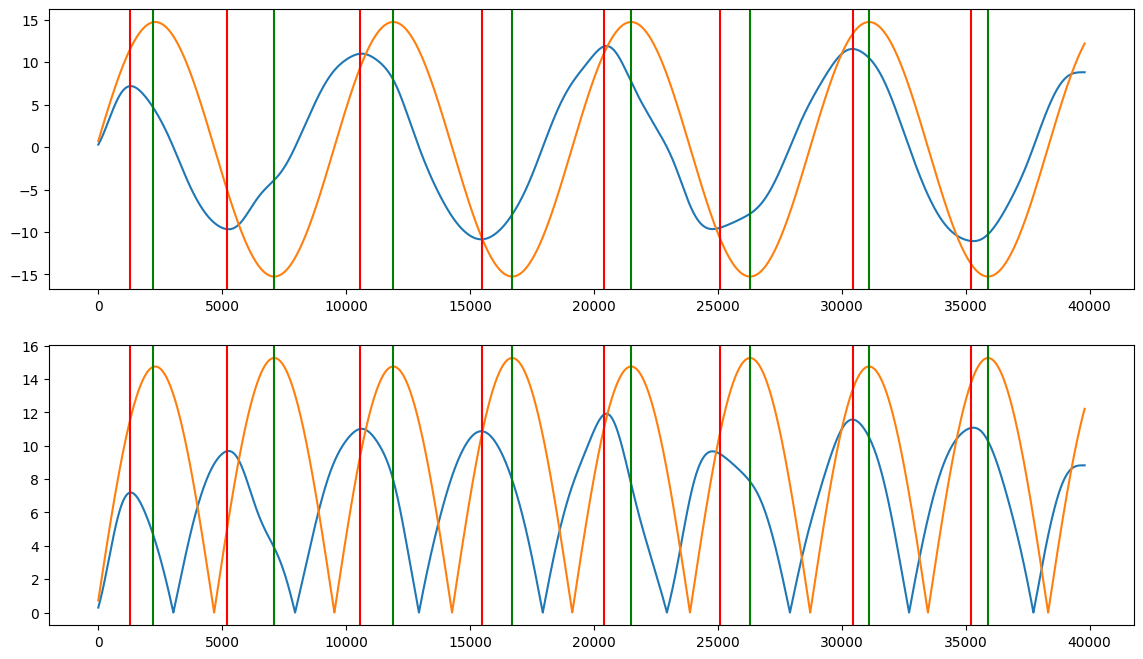

In [4]:
# Antes que nada vamos a quitar las primeras y las últimas muestras
# Con esto evitamos problemas con el escalado
SAMPLES_TO_CUT = 100
cutted_hori_channel = hori_channel[SAMPLES_TO_CUT:-SAMPLES_TO_CUT]
cutted_stim_channel = stim_channel[SAMPLES_TO_CUT:-SAMPLES_TO_CUT]
time_channel = np.arange(len(cutted_hori_channel))

centered_hori_channel = center_signal(cutted_hori_channel)
centered_stim_channel = center_signal(cutted_stim_channel)

# Esta señal hay que invertirla porque al parecer me puse los electrodos al revés
# Hay que poner una opcion en la interfaz gráfica que haga esta operación antes 
# de guardar la señal
inverted_hori_channel = invert_signal(centered_hori_channel)

scaled_hori_channel = scale_channel(inverted_hori_channel, pursuit.angle)
scaled_stim_channel = scale_channel(centered_stim_channel, pursuit.angle)

denoised_hori_channel = denoise(scaled_hori_channel)

peaks_hori_channel = signal.find_peaks_cwt(abs(denoised_hori_channel), 1000)[:-1]
peaks_stim_channel = signal.find_peaks_cwt(abs(scaled_stim_channel), 1000)[:-1]
print("Índices de los Picos")
print(peaks_hori_channel)
print(peaks_stim_channel)
print()

displacements = peaks_stim_channel - peaks_hori_channel
print("Desplazamiento de los Picos")
print(displacements)

to_move = int(round(displacements.mean(), 0))
print("Desplazamiento Medio de los Picos: ", to_move)

PLOT_START, PLOT_END = 0, -1
# PLOT_START, PLOT_END = 0, 10000
plt.subplot(211)
plt.plot(time_channel[PLOT_START:PLOT_END], denoised_hori_channel[PLOT_START:PLOT_END])
plt.plot(time_channel[PLOT_START:PLOT_END], scaled_stim_channel[PLOT_START:PLOT_END])

for hori_peak, stim_peak in zip(peaks_hori_channel, peaks_stim_channel):
    plt.axvline(hori_peak, c='r')
    plt.axvline(stim_peak, c='g')

plt.subplot(212)
plt.plot(time_channel[PLOT_START:PLOT_END], abs(denoised_hori_channel[PLOT_START:PLOT_END]))
plt.plot(time_channel[PLOT_START:PLOT_END], abs(scaled_stim_channel[PLOT_START:PLOT_END]))

for hori_peak, stim_peak in zip(peaks_hori_channel, peaks_stim_channel):
    plt.axvline(hori_peak, c='r')
    plt.axvline(stim_peak, c='g')

## Visualización de la señal Desplazada

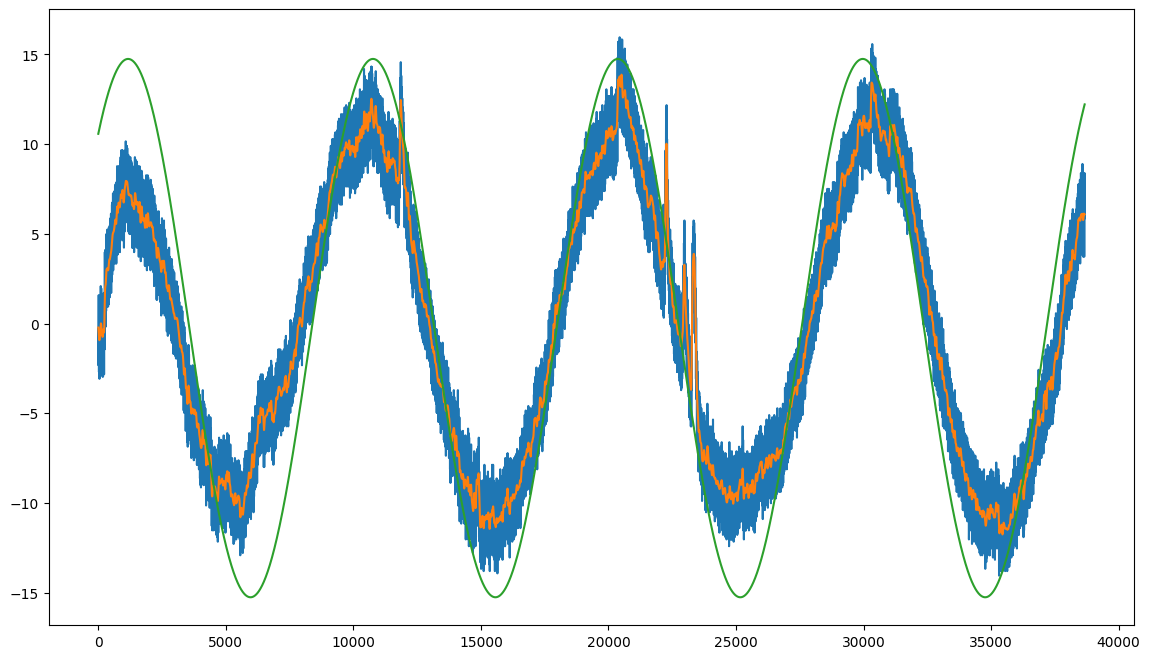

In [8]:
displaced_hori_channel = scaled_hori_channel[:-to_move-1]
displaced_stim_channel = scaled_stim_channel[to_move:-1]
displaced_time_channel = np.arange(len(displaced_hori_channel))

plt.plot(displaced_time_channel, displaced_hori_channel)
plt.plot(displaced_time_channel, denoise_35(displaced_hori_channel))
plt.plot(displaced_time_channel, displaced_stim_channel)